In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

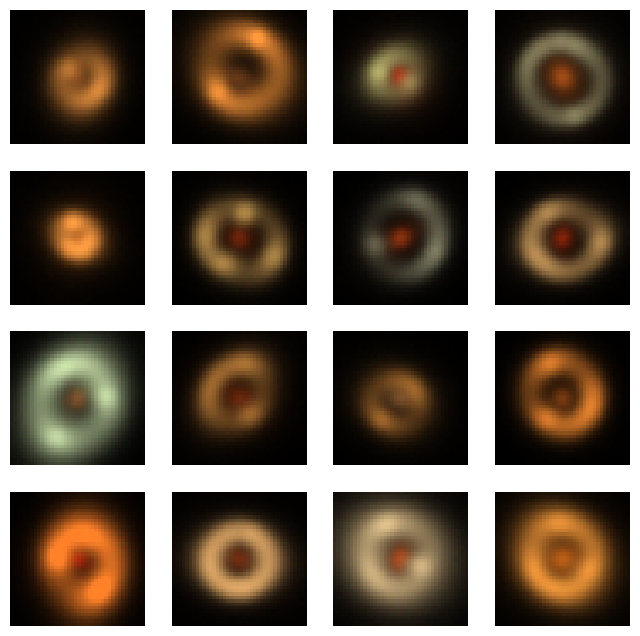

In [4]:
# Visualize source data
visualize_data(source_data)

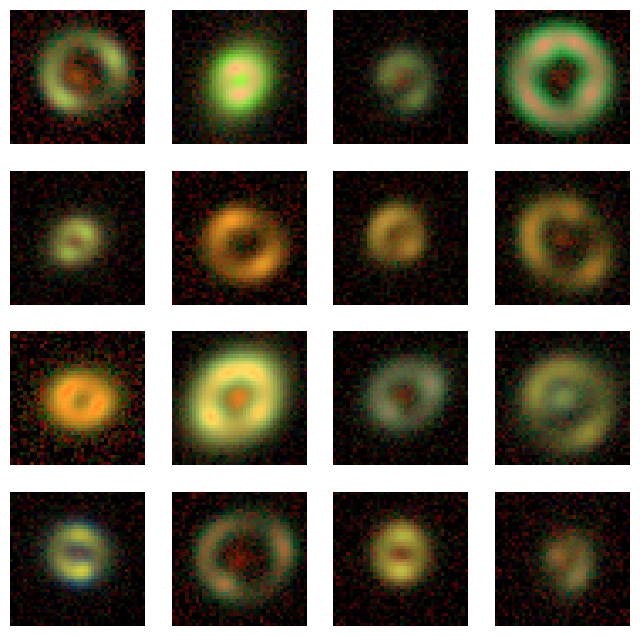

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    if epoch < evolv_epoch_da:
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / evolv_epoch_da))
    else:
        da_weight = final_wt_da
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch_beta:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch_beta)
    elif epoch < evolv_epoch_nll:
        beta_val = beta_final
    else:
        beta_val = 0.0
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5

n_epoch = 250
evolv_epoch_beta = 150
evolv_epoch_nll = 200
evolv_epoch_da = 250

beta_init = 1.0
beta_final = 0.5

init_wt_da = 1.4
final_wt_da = 1.8

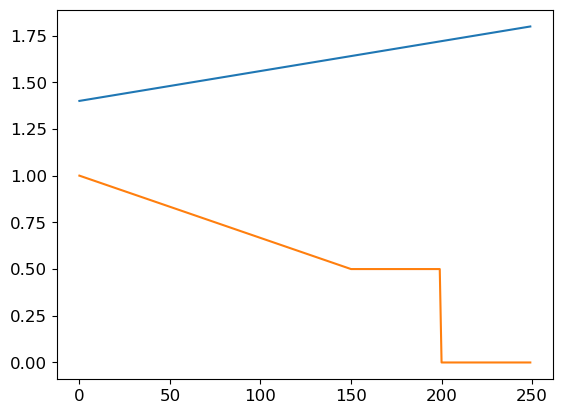

In [7]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

In [8]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[200], gamma=0.04)

In [10]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v7_aug24_1610"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


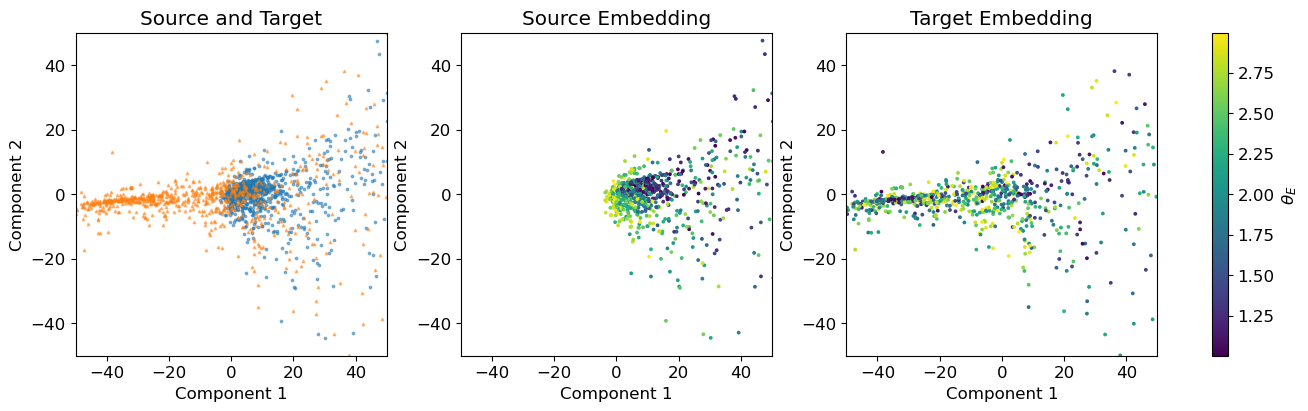


Epoch 0: 32.43s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4657
	Train Regression Loss: : 2.0740
	Train Mve Loss: : 0.8835
	Train R2 Score: : -5.3215
 Validation Statistics:
	Val Source Regression Loss: : 0.7792
	Val Target Regression Loss: : 0.7237
	Val Source R2 Score: : -1.3843
	Val Target R2 Score: : -1.1479
	Val Source Mve Loss: : 0.2336
	Val Target Mve Loss: : 0.2026
	Val Source Nll Loss: : 0.4683
	Val Target Nll Loss: : 0.4784
Saving Model MVE... Done.
Saving Model NLL... Done.

Epoch 1: 31.05s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3152
	Train Regression Loss: : 0.4476
	Train Mve Loss: : 0.0647
	Train R2 Score: : -0.3531
 Validation Statistics:
	Val Source Regression Loss: : 0.2847
	Val Target Regression Loss: : 0.2972
	Val Source R2 Score: : 0.1323
	Val Target R2 Score: : 0.1141
	Val Source Mve Loss: : -0.0216
	Val Target Mve Loss: : -0.0199
	Val Source Nll Loss: : -0.0726
	Val Target Nll Loss: : -0.0428
Saving

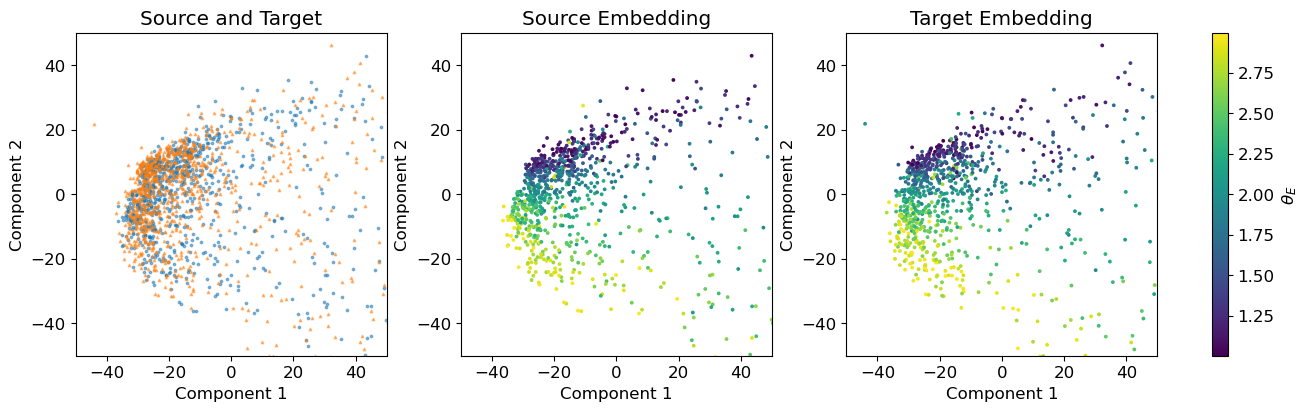

Saving Model... Done.

Epoch 20: 29.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0294
	Train Regression Loss: : 0.0175
	Train Mve Loss: : -0.0537
	Train R2 Score: : 0.9471
 Validation Statistics:
	Val Source Regression Loss: : 0.0178
	Val Target Regression Loss: : 0.0229
	Val Source R2 Score: : 0.9453
	Val Target R2 Score: : 0.9314
	Val Source Mve Loss: : -0.0549
	Val Target Mve Loss: : -0.0547
	Val Source Nll Loss: : 1638.4956
	Val Target Nll Loss: : 2799.7685
Saving Model... Done.

Epoch 21: 32.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0282
	Train Regression Loss: : 0.0168
	Train Mve Loss: : -0.0524
	Train R2 Score: : 0.9492
 Validation Statistics:
	Val Source Regression Loss: : 0.0166
	Val Target Regression Loss: : 0.0225
	Val Source R2 Score: : 0.9490
	Val Target R2 Score: : 0.9330
	Val Source Mve Loss: : -0.0432
	Val Target Mve Loss: : -0.0432
	Val Source Nll Loss: : 4705.9071
	Val Target Nll Loss: : 6429.1364
Sa

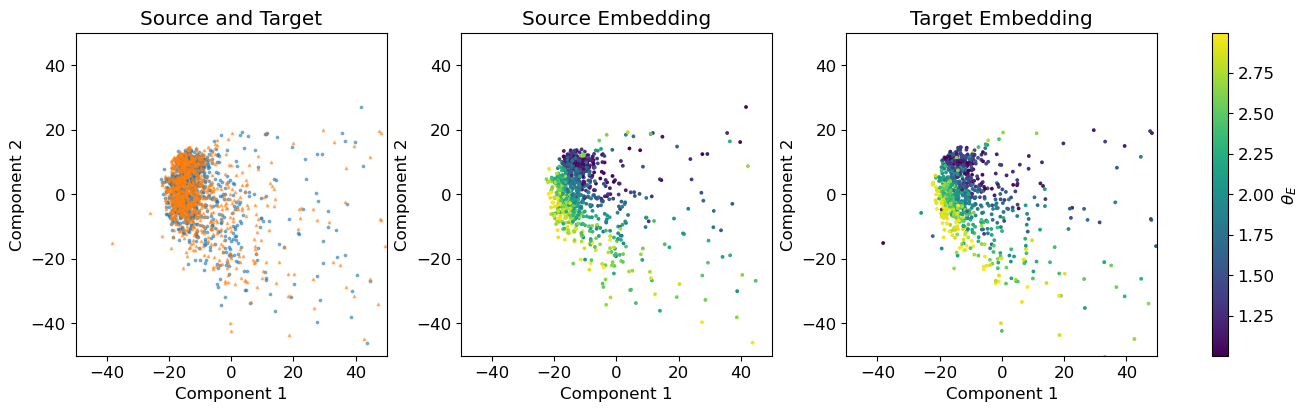


Epoch 40: 30.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0169
	Train Regression Loss: : 0.0136
	Train Mve Loss: : -0.0681
	Train R2 Score: : 0.9586
 Validation Statistics:
	Val Source Regression Loss: : 0.0151
	Val Target Regression Loss: : 0.0201
	Val Source R2 Score: : 0.9538
	Val Target R2 Score: : 0.9405
	Val Source Mve Loss: : -0.1915
	Val Target Mve Loss: : -0.1869
	Val Source Nll Loss: : 986.6813
	Val Target Nll Loss: : 2438.4427
Saving Model MVE... Done.

Epoch 41: 31.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0168
	Train Regression Loss: : 0.0142
	Train Mve Loss: : -0.1920
	Train R2 Score: : 0.9568
 Validation Statistics:
	Val Source Regression Loss: : 0.0144
	Val Target Regression Loss: : 0.0187
	Val Source R2 Score: : 0.9559
	Val Target R2 Score: : 0.9443
	Val Source Mve Loss: : -0.1918
	Val Target Mve Loss: : -0.1883
	Val Source Nll Loss: : 1027.1852
	Val Target Nll Loss: : 1936.2500
Saving Model MVE... D

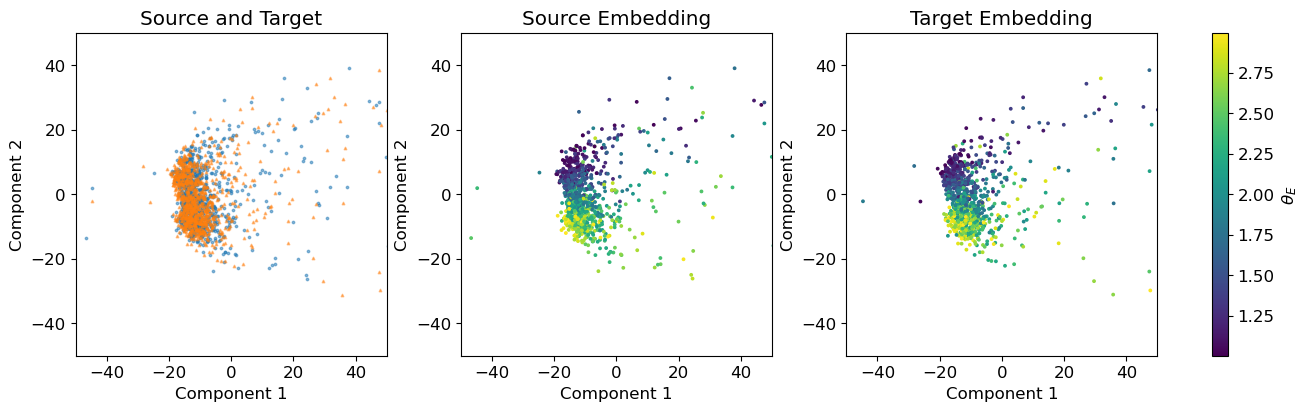


Epoch 60: 33.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0160
	Train Regression Loss: : 0.0130
	Train Mve Loss: : -0.0818
	Train R2 Score: : 0.9605
 Validation Statistics:
	Val Source Regression Loss: : 0.0130
	Val Target Regression Loss: : 0.0171
	Val Source R2 Score: : 0.9602
	Val Target R2 Score: : 0.9489
	Val Source Mve Loss: : -0.0809
	Val Target Mve Loss: : -0.0680
	Val Source Nll Loss: : 329.4909
	Val Target Nll Loss: : 4984.3778

Epoch 61: 32.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0159
	Train Regression Loss: : 0.0135
	Train Mve Loss: : -0.1429
	Train R2 Score: : 0.9590
 Validation Statistics:
	Val Source Regression Loss: : 0.0135
	Val Target Regression Loss: : 0.0211
	Val Source R2 Score: : 0.9588
	Val Target R2 Score: : 0.9368
	Val Source Mve Loss: : -0.1763
	Val Target Mve Loss: : -0.1285
	Val Source Nll Loss: : 4708.3878
	Val Target Nll Loss: : 21369.4151

Epoch 62: 32.98s
----------------------------

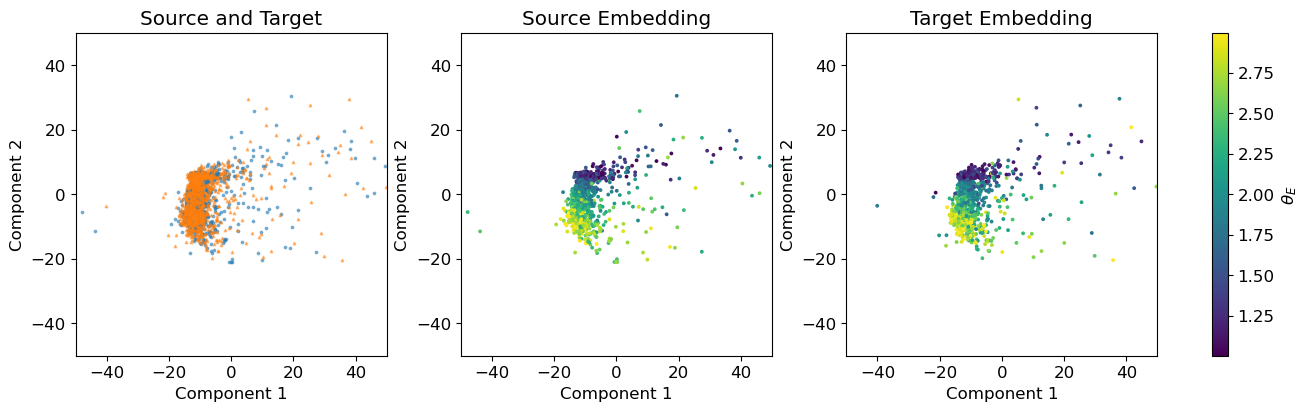

Saving Model MVE... Done.
Saving Model NLL... Done.

Epoch 80: 34.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0141
	Train Regression Loss: : 0.0131
	Train Mve Loss: : -0.1784
	Train R2 Score: : 0.9602
 Validation Statistics:
	Val Source Regression Loss: : 0.0132
	Val Target Regression Loss: : 0.0182
	Val Source R2 Score: : 0.9592
	Val Target R2 Score: : 0.9453
	Val Source Mve Loss: : -0.1336
	Val Target Mve Loss: : -0.0999
	Val Source Nll Loss: : 278.7190
	Val Target Nll Loss: : 3623.6930

Epoch 81: 34.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0137
	Train Regression Loss: : 0.0130
	Train Mve Loss: : -0.1367
	Train R2 Score: : 0.9606
 Validation Statistics:
	Val Source Regression Loss: : 0.0132
	Val Target Regression Loss: : 0.0189
	Val Source R2 Score: : 0.9592
	Val Target R2 Score: : 0.9442
	Val Source Mve Loss: : -0.1225
	Val Target Mve Loss: : -0.0892
	Val Source Nll Loss: : 65.7523
	Val Target Nll Loss: : 3104.90

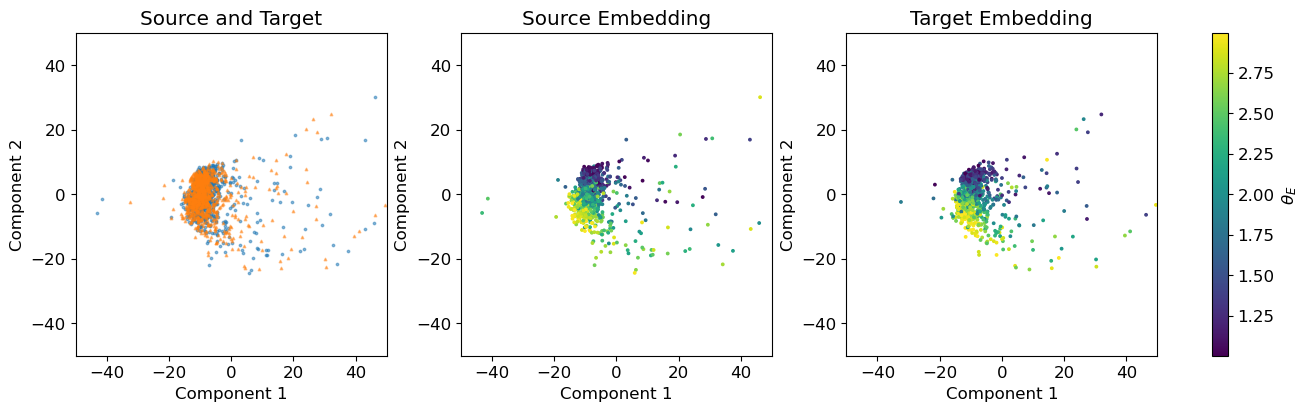


Epoch 100: 34.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0121
	Train Regression Loss: : 0.0125
	Train Mve Loss: : -0.2440
	Train R2 Score: : 0.9620
 Validation Statistics:
	Val Source Regression Loss: : 0.0119
	Val Target Regression Loss: : 0.0175
	Val Source R2 Score: : 0.9634
	Val Target R2 Score: : 0.9480
	Val Source Mve Loss: : -0.2644
	Val Target Mve Loss: : -0.2248
	Val Source Nll Loss: : -0.7015
	Val Target Nll Loss: : 1630.8062

Epoch 101: 31.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0120
	Train Regression Loss: : 0.0120
	Train Mve Loss: : -0.2653
	Train R2 Score: : 0.9637
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.0205
	Val Source R2 Score: : 0.9637
	Val Target R2 Score: : 0.9391
	Val Source Mve Loss: : -0.2647
	Val Target Mve Loss: : -0.2562
	Val Source Nll Loss: : -0.7745
	Val Target Nll Loss: : 6.2433
Saving Model MVE... Done.

Epoch 102: 32.84s
------

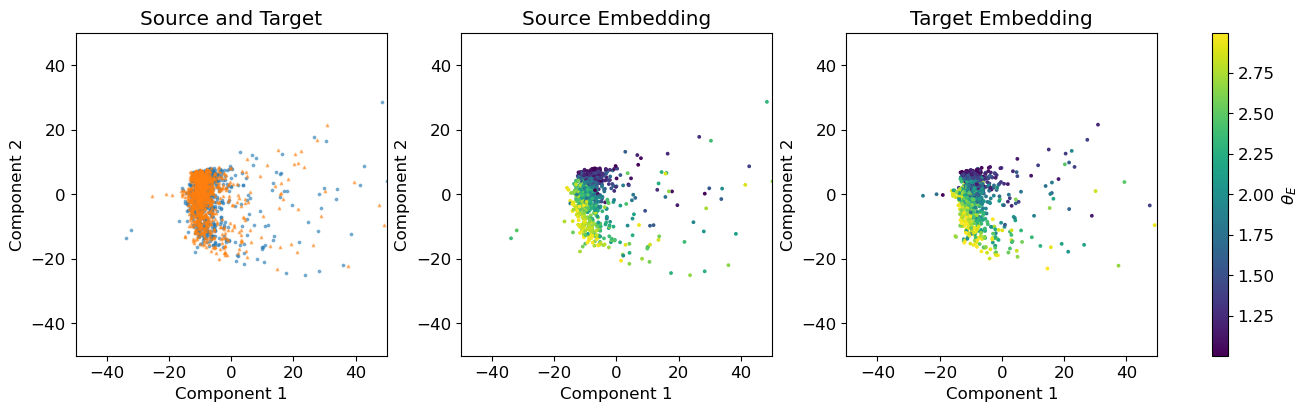


Epoch 120: 33.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0112
	Train Regression Loss: : 0.0111
	Train Mve Loss: : -0.2759
	Train R2 Score: : 0.9662
 Validation Statistics:
	Val Source Regression Loss: : 0.0113
	Val Target Regression Loss: : 0.0151
	Val Source R2 Score: : 0.9649
	Val Target R2 Score: : 0.9551
	Val Source Mve Loss: : -0.2859
	Val Target Mve Loss: : -0.2826
	Val Source Nll Loss: : -0.8744
	Val Target Nll Loss: : -0.8597
Saving Model... Done.
Saving Model MVE... Done.

Epoch 121: 32.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0114
	Train Regression Loss: : 0.0112
	Train Mve Loss: : -0.2822
	Train R2 Score: : 0.9661
 Validation Statistics:
	Val Source Regression Loss: : 0.0117
	Val Target Regression Loss: : 0.0155
	Val Source R2 Score: : 0.9638
	Val Target R2 Score: : 0.9537
	Val Source Mve Loss: : -0.2720
	Val Target Mve Loss: : -0.2688
	Val Source Nll Loss: : -1.0418
	Val Target Nll Loss: : -1.0188
Savi

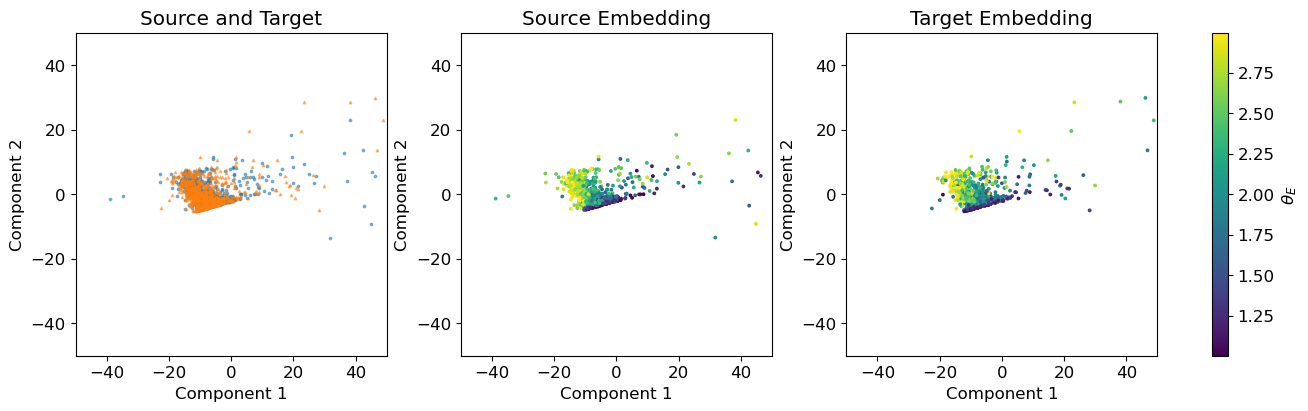


Epoch 140: 35.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0116
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.2333
	Train R2 Score: : 0.9652
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.0175
	Val Source R2 Score: : 0.9642
	Val Target R2 Score: : 0.9442
	Val Source Mve Loss: : -0.1545
	Val Target Mve Loss: : 0.2053
	Val Source Nll Loss: : 413.0234
	Val Target Nll Loss: : 2232.8883

Epoch 141: 34.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0117
	Train Regression Loss: : 0.0118
	Train Mve Loss: : -0.2477
	Train R2 Score: : 0.9642
 Validation Statistics:
	Val Source Regression Loss: : 0.0122
	Val Target Regression Loss: : 0.0188
	Val Source R2 Score: : 0.9623
	Val Target R2 Score: : 0.9439
	Val Source Mve Loss: : -0.2935
	Val Target Mve Loss: : -0.1418
	Val Source Nll Loss: : 19.8687
	Val Target Nll Loss: : 732.6526

Epoch 142: 33.60s
------------------------------

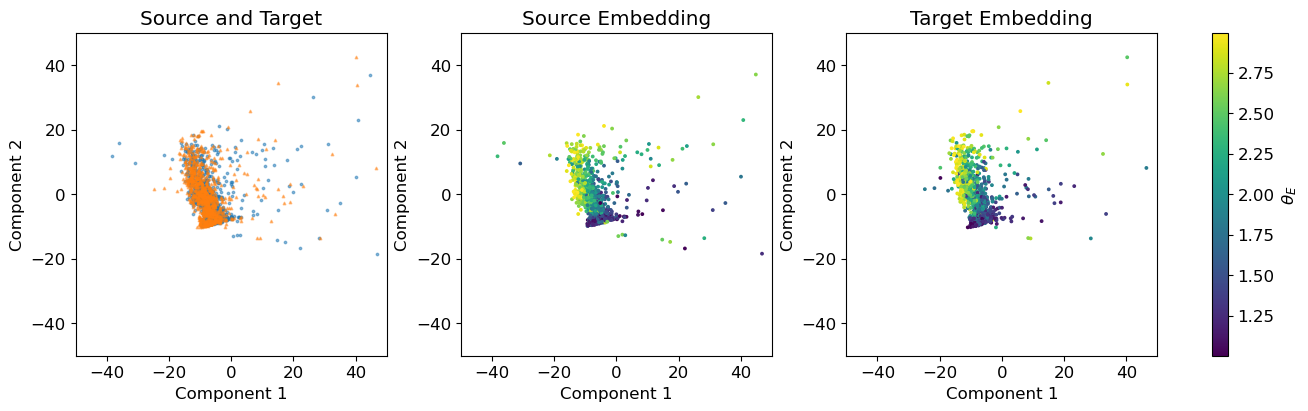


Epoch 160: 31.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0115
	Train Regression Loss: : 0.0108
	Train Mve Loss: : -0.3378
	Train R2 Score: : 0.9672
 Validation Statistics:
	Val Source Regression Loss: : 0.0109
	Val Target Regression Loss: : 0.0153
	Val Source R2 Score: : 0.9667
	Val Target R2 Score: : 0.9539
	Val Source Mve Loss: : -0.3396
	Val Target Mve Loss: : -0.3333
	Val Source Nll Loss: : -0.7446
	Val Target Nll Loss: : -0.7199
Saving Model MVE... Done.

Epoch 161: 31.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0110
	Train Regression Loss: : 0.0108
	Train Mve Loss: : -0.3415
	Train R2 Score: : 0.9674
 Validation Statistics:
	Val Source Regression Loss: : 0.0108
	Val Target Regression Loss: : 0.0159
	Val Source R2 Score: : 0.9668
	Val Target R2 Score: : 0.9529
	Val Source Mve Loss: : -0.3431
	Val Target Mve Loss: : -0.3358
	Val Source Nll Loss: : -0.8021
	Val Target Nll Loss: : -0.7690
Saving Model MVE... Done.


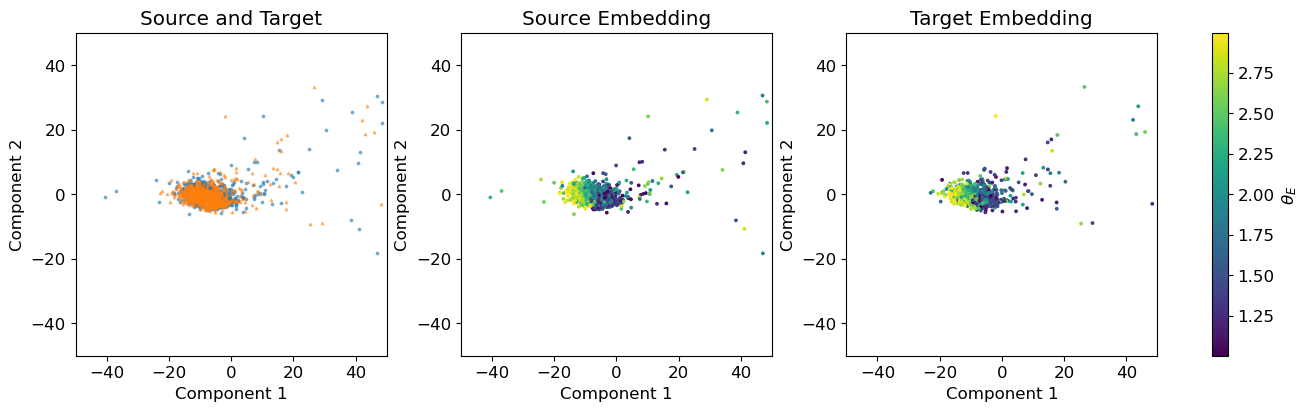


Epoch 180: 40.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0106
	Train Regression Loss: : 0.0104
	Train Mve Loss: : -0.3109
	Train R2 Score: : 0.9684
 Validation Statistics:
	Val Source Regression Loss: : 0.0111
	Val Target Regression Loss: : 0.0166
	Val Source R2 Score: : 0.9664
	Val Target R2 Score: : 0.9500
	Val Source Mve Loss: : -0.3066
	Val Target Mve Loss: : -0.1343
	Val Source Nll Loss: : 8.0300
	Val Target Nll Loss: : 558.3246

Epoch 181: 33.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0117
	Train Regression Loss: : 0.0106
	Train Mve Loss: : -0.2800
	Train R2 Score: : 0.9680
 Validation Statistics:
	Val Source Regression Loss: : 0.0104
	Val Target Regression Loss: : 0.0175
	Val Source R2 Score: : 0.9682
	Val Target R2 Score: : 0.9490
	Val Source Mve Loss: : -0.3084
	Val Target Mve Loss: : -0.1509
	Val Source Nll Loss: : -1.3480
	Val Target Nll Loss: : 497.4977

Epoch 182: 34.63s
-------------------------------


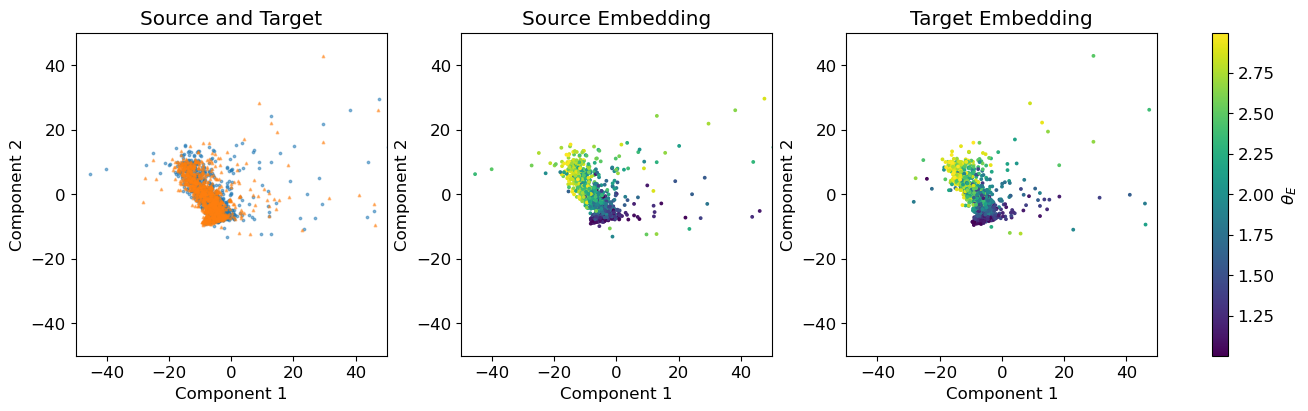


Epoch 200: 31.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0108
	Train Regression Loss: : 0.0098
	Train Mve Loss: : 181.7182
	Train R2 Score: : 0.9702
 Validation Statistics:
	Val Source Regression Loss: : 0.0100
	Val Target Regression Loss: : 0.0163
	Val Source R2 Score: : 0.9694
	Val Target R2 Score: : 0.9516
	Val Source Mve Loss: : 254.3687
	Val Target Mve Loss: : 9502.2090
	Val Source Nll Loss: : 254.3687
	Val Target Nll Loss: : 9502.2090

Epoch 201: 31.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0109
	Train Regression Loss: : 0.0098
	Train Mve Loss: : 167.9993
	Train R2 Score: : 0.9702
 Validation Statistics:
	Val Source Regression Loss: : 0.0100
	Val Target Regression Loss: : 0.0155
	Val Source R2 Score: : 0.9696
	Val Target R2 Score: : 0.9543
	Val Source Mve Loss: : 426.9320
	Val Target Mve Loss: : 1927.9723
	Val Source Nll Loss: : 426.9320
	Val Target Nll Loss: : 1927.9723

Epoch 202: 32.13s
-------------------

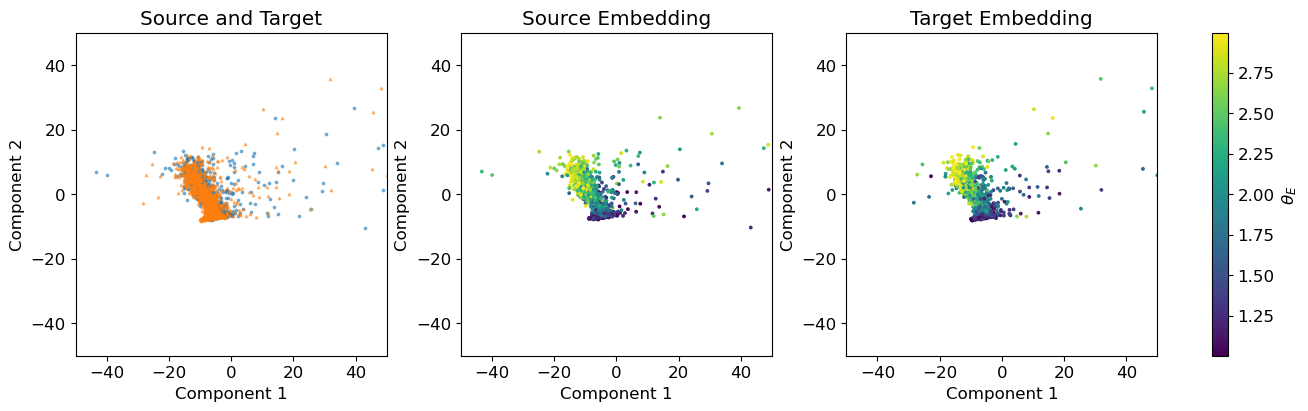


Epoch 220: 31.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0107
	Train Regression Loss: : 0.0099
	Train Mve Loss: : 7.3681
	Train R2 Score: : 0.9702
 Validation Statistics:
	Val Source Regression Loss: : 0.0103
	Val Target Regression Loss: : 0.0155
	Val Source R2 Score: : 0.9689
	Val Target R2 Score: : 0.9536
	Val Source Mve Loss: : 23.3726
	Val Target Mve Loss: : 2320.0646
	Val Source Nll Loss: : 23.3726
	Val Target Nll Loss: : 2320.0646

Epoch 221: 31.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0110
	Train Regression Loss: : 0.0100
	Train Mve Loss: : 17.0917
	Train R2 Score: : 0.9697
 Validation Statistics:
	Val Source Regression Loss: : 0.0107
	Val Target Regression Loss: : 0.0161
	Val Source R2 Score: : 0.9674
	Val Target R2 Score: : 0.9521
	Val Source Mve Loss: : 27.0846
	Val Target Mve Loss: : 1218.0659
	Val Source Nll Loss: : 27.0846
	Val Target Nll Loss: : 1218.0659

Epoch 222: 31.71s
--------------------------

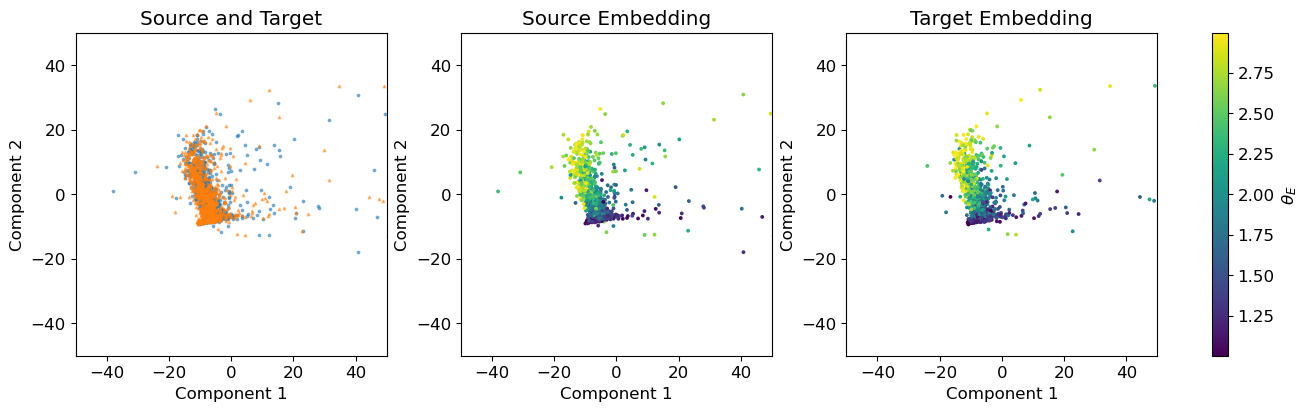


Epoch 240: 31.55s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0103
	Train Regression Loss: : 0.0103
	Train Mve Loss: : 10.8676
	Train R2 Score: : 0.9687
 Validation Statistics:
	Val Source Regression Loss: : 0.0106
	Val Target Regression Loss: : 0.0158
	Val Source R2 Score: : 0.9674
	Val Target R2 Score: : 0.9513
	Val Source Mve Loss: : 21.1071
	Val Target Mve Loss: : 77.4006
	Val Source Nll Loss: : 21.1071
	Val Target Nll Loss: : 77.4006

Epoch 241: 33.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0110
	Train Regression Loss: : 0.0104
	Train Mve Loss: : 15.2421
	Train R2 Score: : 0.9686
 Validation Statistics:
	Val Source Regression Loss: : 0.0105
	Val Target Regression Loss: : 0.0152
	Val Source R2 Score: : 0.9677
	Val Target R2 Score: : 0.9534
	Val Source Mve Loss: : 1.5361
	Val Target Mve Loss: : 251.5199
	Val Source Nll Loss: : 1.5361
	Val Target Nll Loss: : 251.5199

Epoch 242: 32.76s
-------------------------------
 

In [11]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [12]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [28]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

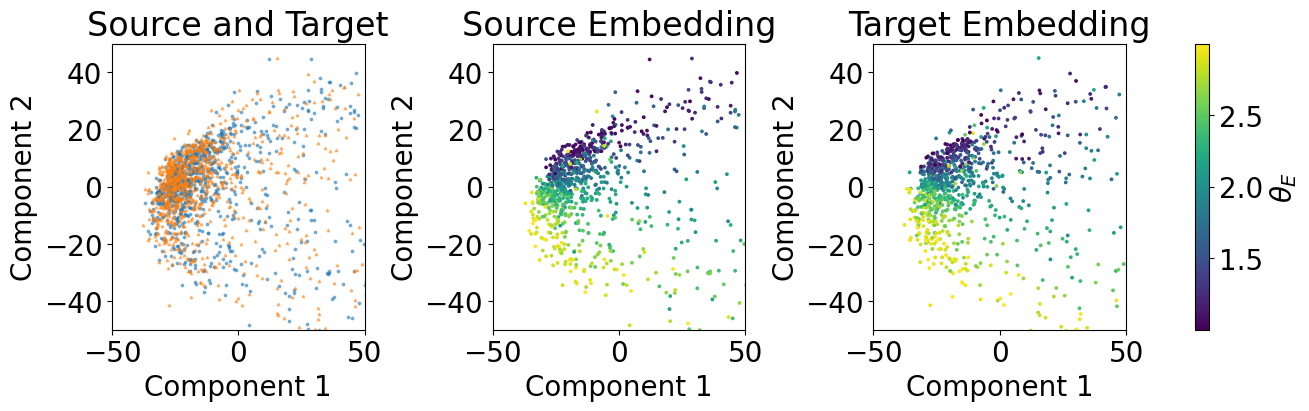

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [29]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

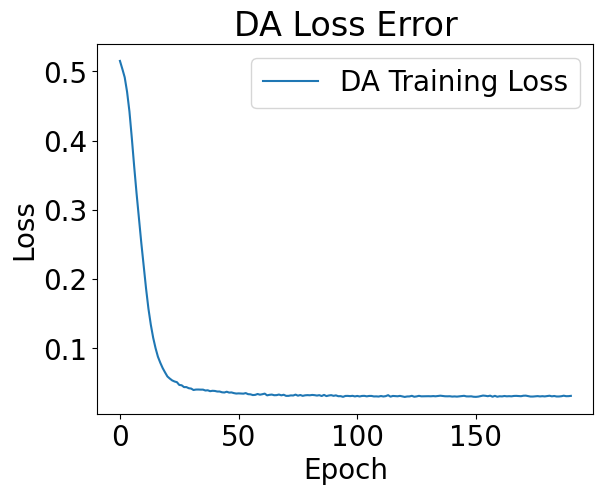

In [30]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

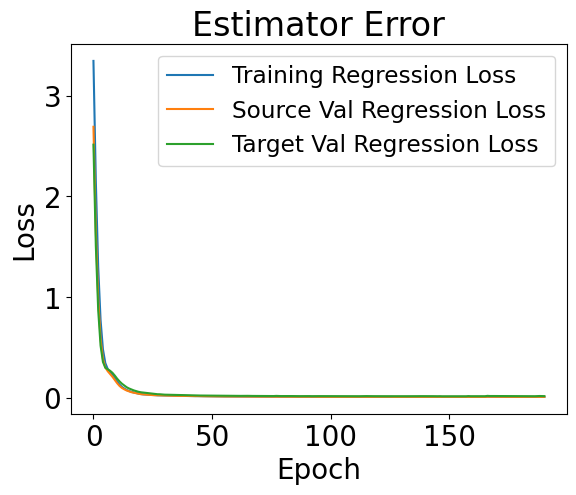

In [31]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

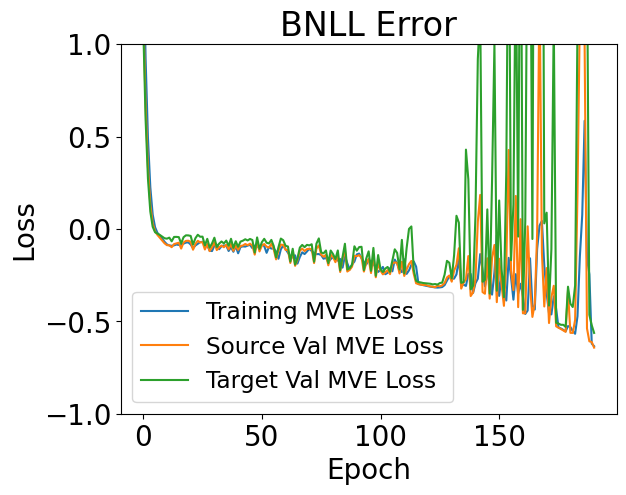

In [32]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

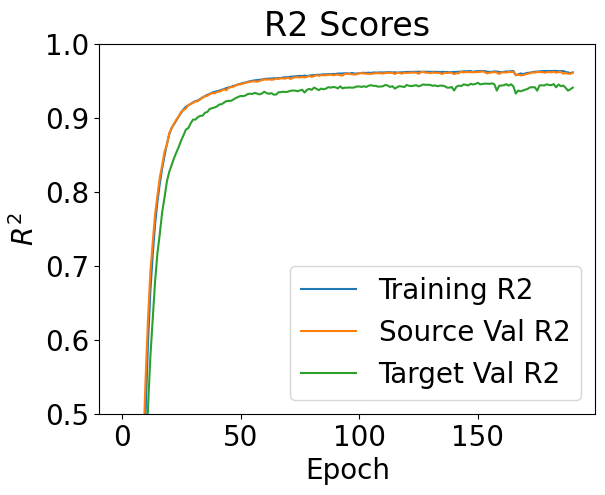

In [33]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [34]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9613


Text(0.5, 1.0, 'MMD | Source | R2: 0.961')

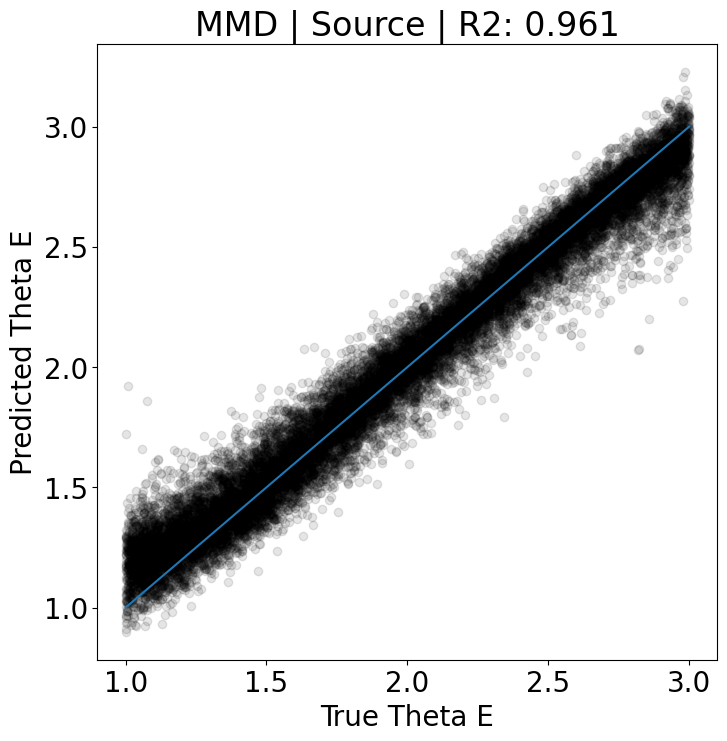

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.308')

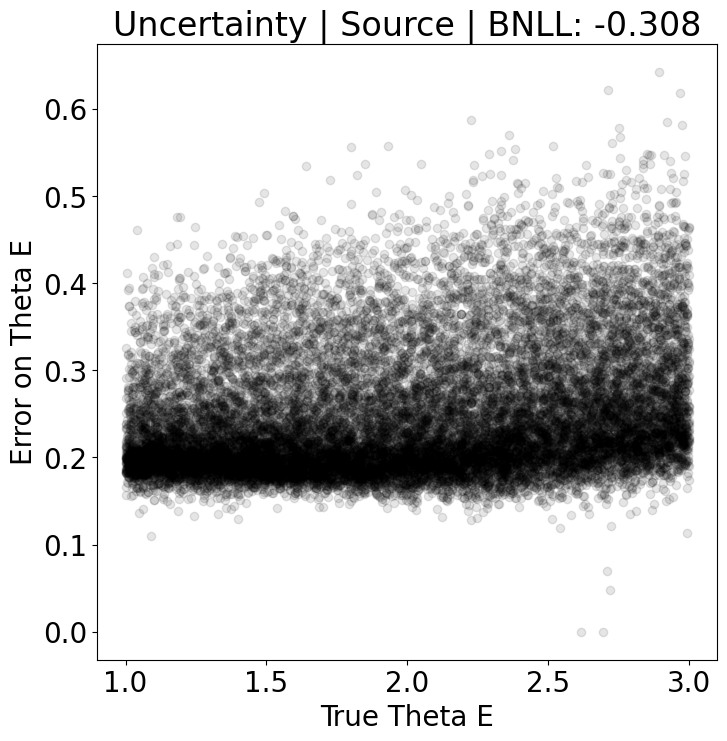

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [37]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9382


Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

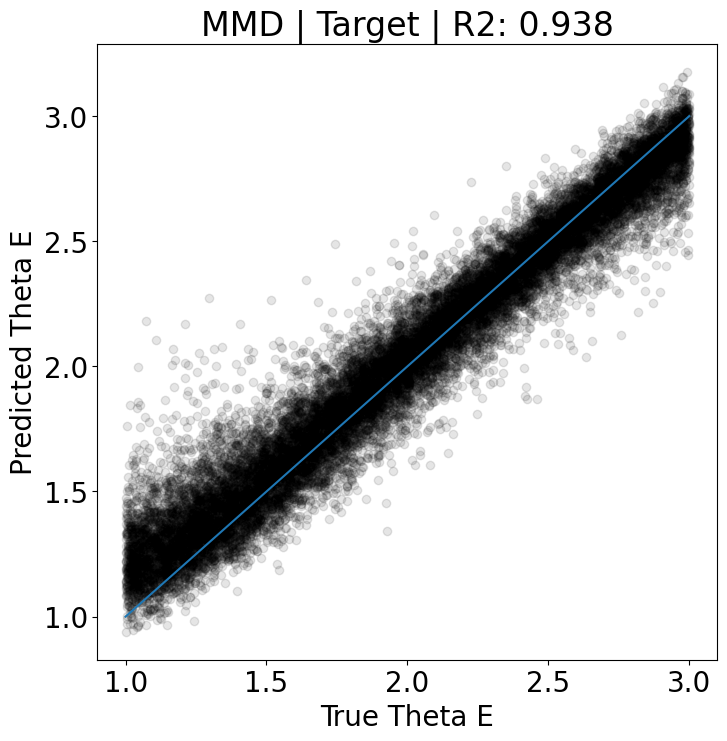

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

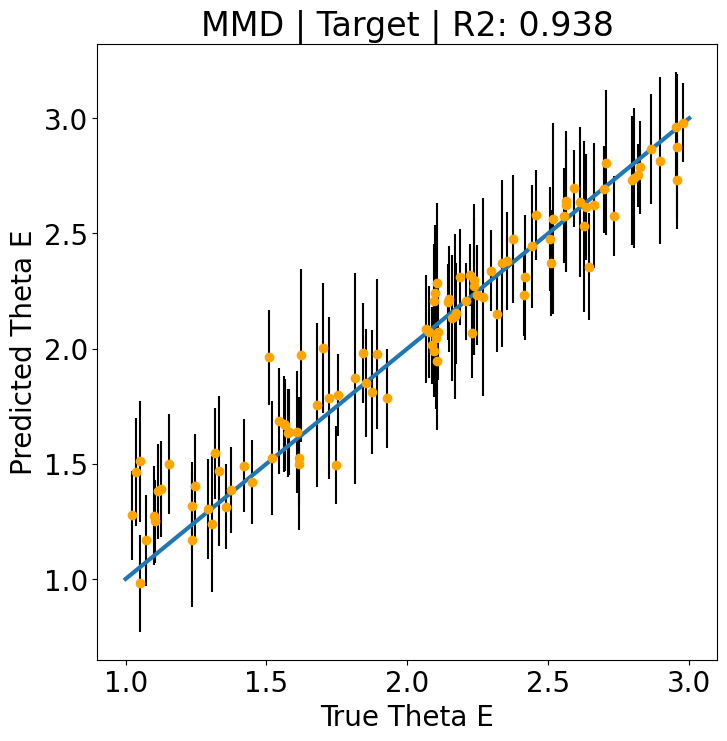

In [39]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.291')

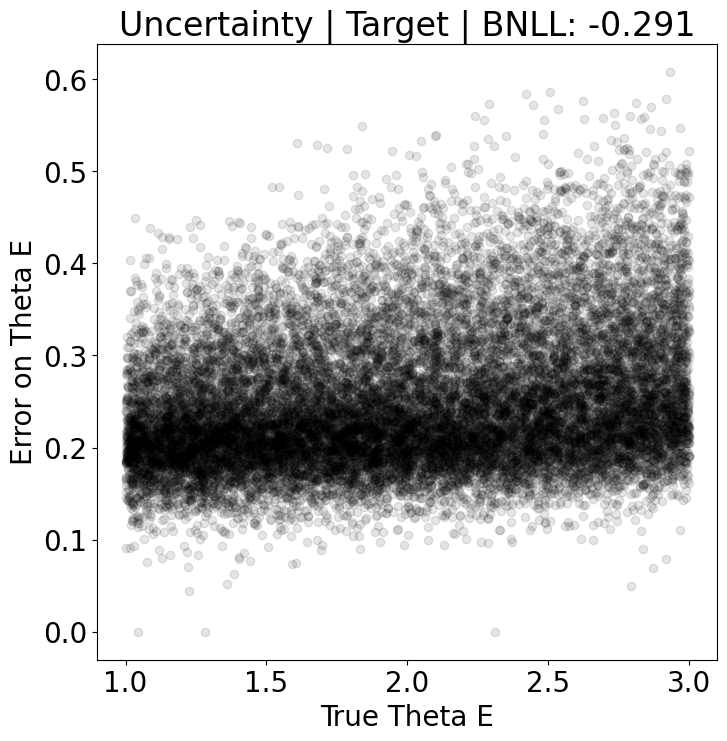

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [41]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

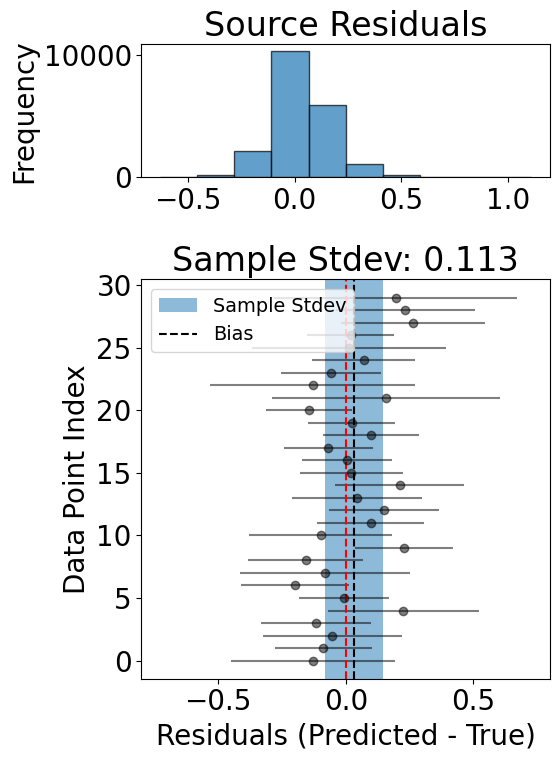

In [42]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

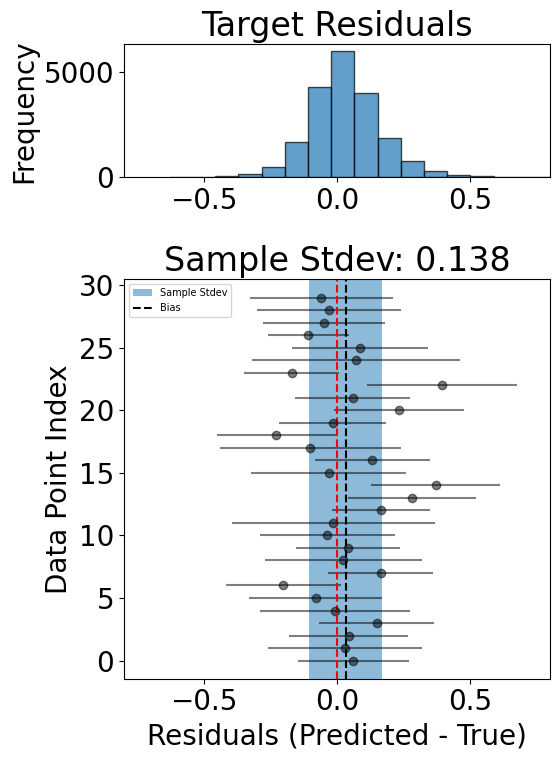

In [43]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()